# Predictive Modelling for Classification

## Import libraries

In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
from datetime import datetime
import pandas as pd
from scripts.helper import reduce_mem_usage
from pycaret.classification import *
from pycaret.utils import check_metric
from pycaret.datasets import get_data
import pickle
pd.set_option("display.max_columns", 120)

## Import data

In [2]:
# Create datetime
today = datetime.today()
d1 = today.strftime("%d%m%Y")

In [3]:
# Test dataset from pycaret library for classification modelling
# Comment it out if you're using the Capstone dataset!
#dataset_pycaret = get_data('credit')
dataset = pd.read_csv('data/feat_train_v2.csv')
dataset_test = pd.read_csv('data/feat_test_v2.csv')

In [4]:
#dataset_pycaret.info()

## Preparation for Modelling

In [5]:
numerical_cols = np.load("data/Numerical_Columns.npy")
categorical_cols = np.load("data/Categorical_Columns.npy")

In [6]:
type(numerical_cols)

numpy.ndarray

In [7]:
numerical_cols = numerical_cols.tolist()
categorical_cols = categorical_cols.tolist()

In [8]:
type(numerical_cols)

list

In [9]:
# Create target for classification model
class_train = dataset[categorical_cols+numerical_cols]
class_train['Target'] = dataset['totals.transactionRevenue'].apply(lambda x: 0 if x == 0 else 1)

class_test = dataset_test[categorical_cols+numerical_cols]
class_test['Target'] = dataset_test['totals.transactionRevenue'].apply(lambda x: 0 if x == 0 else 1)

### Removing some zeros!

In [10]:
totals_transactionRevenue_zero = class_train[class_train['Target'] == 0].sample(frac=0.25, random_state=123)
totals_transactionRevenue_nonzero = class_train[class_train['Target'] != 0]
class_train = pd.concat([totals_transactionRevenue_zero, totals_transactionRevenue_nonzero], axis=0)

In [11]:
class_train.head()

,channelGrouping,device.browser,device.operatingSystem,geoNetwork.city,geoNetwork.country,geoNetwork.networkDomain,geoNetwork.region,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,Week,Month,hits_mean_city,pageviews_mean_city,Target
1346843,4,55,7,531,218,0,141,48,4,0,8,5,0,117,1.0,0.0,1.0,1.0,1.0,1.0,11.0,3.0,3.0,2.0,0
91085,7,102,7,436,211,43282,210,48,4,0,8,6,3193,386,1.0,0.0,1.0,1.0,1.0,1.0,41.0,10.0,2.0,2.0,0
1566695,6,55,7,1096,219,9601,517,48,4,0,8,0,2,0,1.0,0.0,0.0,4.0,1.0,4.0,42.0,10.0,4.0,3.0,0
1092396,3,55,1,1096,219,39437,517,37,6,1,5,3,0,117,2.0,1.0,1.0,1.0,0.0,1.0,34.0,8.0,4.0,3.0,0
1706822,4,102,25,1096,161,44691,517,48,4,0,8,0,0,0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,4.0,3.0,0


## Binary Classification

Binary classification is a supervised machine learning technique where the goal is to predict categorical class labels which are discrete and unoredered such as Pass/Fail, Positive/Negative, Default/Not-Default etc. A few real world use cases for classification are listed below:

Medical testing to determine if a patient has a certain disease or not - the classification property is the presence of the disease.
A "pass or fail" test method or quality control in factories, i.e. deciding if a specification has or has not been met – a go/no-go classification.
Information retrieval, namely deciding whether a page or an article should be in the result set of a search or not – the classification property is the relevance of the article, or the usefulness to the user.

In order to demonstrate the predict_model() function on unseen data, a sample of xxxxx records has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these xxxxx records are not available at the time when the machine learning experiment was performed.

In [12]:

data_unseen = class_test
#data.reset_index(inplace=True, drop=True)
#data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(class_train.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))


Data for Modeling: (440970, 25)
Unseen Data For Predictions: (401589, 25)


## 1.0 Setting up environment in PyCaret

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [13]:
print(class_train.info())
# class_train[categorical_cols] = class_train[categorical_cols].astype('category')
# class_test[categorical_cols] = class_test[categorical_cols].astype('category')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440970 entries, 1346843 to 1708001
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   channelGrouping             440970 non-null  int64  
 1   device.browser              440970 non-null  int64  
 2   device.operatingSystem      440970 non-null  int64  
 3   geoNetwork.city             440970 non-null  int64  
 4   geoNetwork.country          440970 non-null  int64  
 5   geoNetwork.networkDomain    440970 non-null  int64  
 6   geoNetwork.region           440970 non-null  int64  
 7   trafficSource.adContent     440970 non-null  int64  
 8   trafficSource.campaign      440970 non-null  int64  
 9   trafficSource.isTrueDirect  440970 non-null  int64  
 10  trafficSource.keyword       440970 non-null  int64  
 11  trafficSource.medium        440970 non-null  int64  
 12  trafficSource.referralPath  440970 non-null  int64  
 13  traffic

In [14]:
exp_clf101 = setup(data = class_train, target = 'Target', session_id=123, data_split_stratify = True, fold_strategy = 'stratifiedkfold', fix_imbalance = True, numeric_features = categorical_cols+numerical_cols)

,Description,Value
0,session_id,123
1,Target,Target
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(440970, 25)"
5,Missing Values,False
6,Numeric Features,24
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## 2.0 Comparing all models

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using stratified cross validation for metric evaluation. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC accross the folds (10 by default) along with training times.

In [15]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


## Comparing models - Dont run if you have just one model, skip to next part

In [521]:
# start_time = datetime.now()
# best_model = compare_models(['lightgbm'])
# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))

Two simple words of code (not even a line) have trained and evaluated over 15 models using cross validation. The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') will sort the grid by Recall instead of Accuracy. If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using n_select parameter.

In [522]:
print(best_model)

NameError: name 'best_model' is not defined

## 3.0 Create a Model

create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa and MCC by fold.

There are 18 classifiers available in the model library of PyCaret. To see list of all classifiers either check the docstring or use models function to see the library.

### 3.1 LGBM

In [556]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9723,0.9869,0.8032,0.6348,0.7091,0.6948,0.7001
1,0.9741,0.9880,0.8117,0.6542,0.7245,0.7111,0.7156
2,0.9729,0.9876,0.8171,0.6387,0.7170,0.7030,0.7089
3,0.9717,0.9870,0.8032,0.6271,0.7043,0.6897,0.6955
4,0.9718,0.9869,0.7886,0.6320,0.7017,0.6871,0.6917
5,0.9727,0.9869,0.8187,0.6357,0.7157,0.7016,0.7078
6,0.9722,0.9869,0.8133,0.6311,0.7107,0.6964,0.7025
7,0.9719,0.9869,0.8079,0.6288,0.7072,0.6927,0.6987
8,0.9738,0.9883,0.8210,0.6480,0.7243,0.7107,0.7162
9,0.9714,0.9868,0.8040,0.6236,0.7024,0.6876,0.6938


#### Example for Hyperparameter Tuning on GPU with 3.2 XGBoost Classifier

## 4. Tune a Model

When a model is created using the create_model() function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC by fold for the best model. To use the custom search grid, you can pass custom_grid parameter in the tune_model function (KNN tuning below).

### 4.1 LGBM Tuning

In [96]:
#tuned_lgbm = tune_model(lgbm)

In [97]:
print(tuned_lgbm)

NameError: name 'tuned_lgbm' is not defined

### ...

## 5. Plot a Model

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

There are 15 different plots available, please see the plot_model() docstring for the list of available plots.

### 5.1 AUC Plot

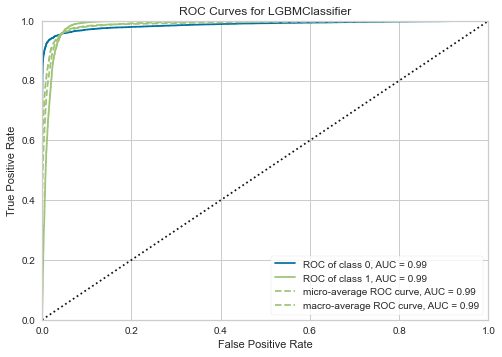

In [469]:
plot_model(lgbm, plot = 'auc')

### 5.2 Precision-Recall Curve

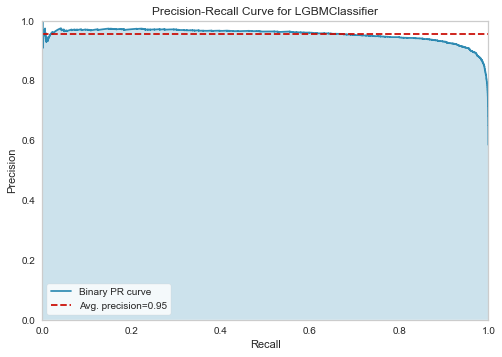

In [470]:
plot_model(lgbm, plot = 'pr')

### 5.3 Feature Importance Plot

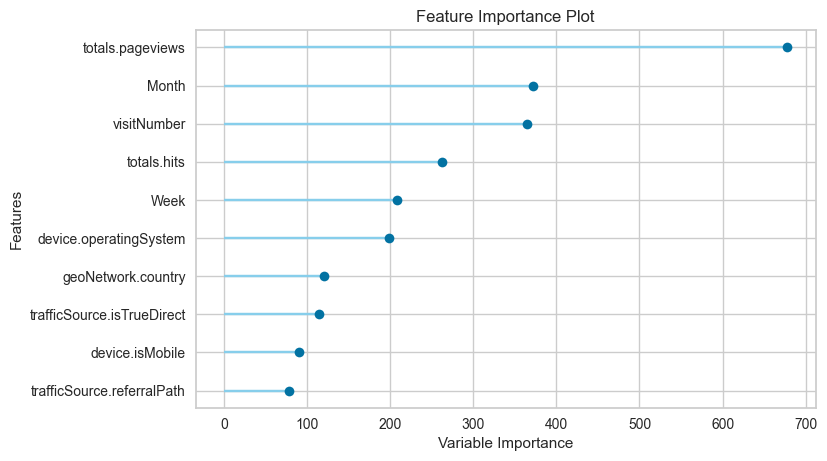

In [557]:
plot_model(lgbm, plot='feature')

### 5.4 Confusion Matrix

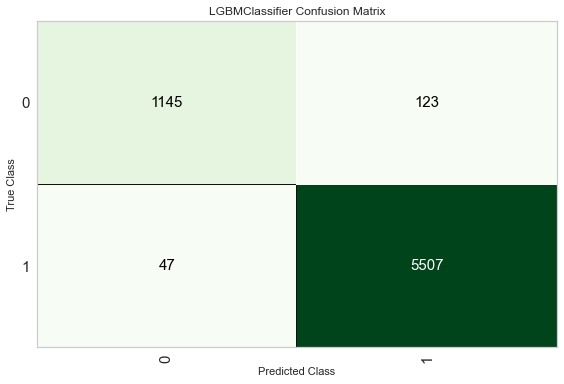

In [537]:
plot_model(lgbm, plot = 'confusion_matrix')

Another way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [473]:
#evaluate_model(lgbm)

## 6 Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. Now, using our final trained model stored in the tuned_rf variable we will predict against the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [558]:
predict_model(lgbm) # use tuned_lgbm

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9725,0.9868,0.8073,0.6356,0.7112,0.6970,0.7025


,channelGrouping,device.browser,device.operatingSystem,geoNetwork.city,geoNetwork.country,geoNetwork.networkDomain,geoNetwork.region,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,...,totals.hits,totals.newVisits,totals.pageviews,Week,Month,hits_mean_city,pageviews_mean_city,Target,Label,Score
0,4.0,102.0,25.0,266.0,219.0,0.0,462.0,48.0,4.0,0.0,...,3.0,1.0,3.0,48.0,11.0,4.0,3.0,0,0,0.9999
1,4.0,63.0,22.0,1096.0,12.0,22141.0,517.0,48.0,4.0,0.0,...,2.0,1.0,2.0,5.0,2.0,4.0,3.0,0,0,0.9999
2,4.0,55.0,22.0,830.0,144.0,19269.0,420.0,48.0,4.0,0.0,...,1.0,1.0,1.0,45.0,11.0,8.0,6.0,0,0,0.9999
3,4.0,55.0,22.0,994.0,36.0,41382.0,327.0,48.0,4.0,0.0,...,17.0,1.0,14.0,46.0,11.0,5.0,4.0,0,0,0.9771
4,4.0,104.0,1.0,441.0,94.0,44691.0,212.0,48.0,4.0,0.0,...,1.0,1.0,1.0,48.0,11.0,2.0,2.0,0,0,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132287,4.0,64.0,1.0,1096.0,53.0,18521.0,517.0,48.0,4.0,0.0,...,4.0,1.0,3.0,39.0,10.0,4.0,3.0,0,0,0.9999
132288,2.0,55.0,1.0,1096.0,93.0,0.0,517.0,48.0,4.0,1.0,...,1.0,0.0,1.0,23.0,6.0,4.0,3.0,0,0,0.9999
132289,4.0,55.0,22.0,1096.0,102.0,18642.0,517.0,48.0,4.0,0.0,...,6.0,0.0,3.0,20.0,5.0,4.0,3.0,0,0,0.9999
132290,4.0,55.0,1.0,893.0,219.0,0.0,502.0,48.0,4.0,0.0,...,3.0,1.0,3.0,45.0,11.0,6.0,5.0,0,0,0.9999


## 7 Finalize Model for Deplyoment

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [559]:
final_lgbm = finalize_model(lgbm) # use tuned lgbm

In [476]:
# Final Random Forest model parameters for deployment
print(final_lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


Caution: One final word of caution. Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

In [560]:
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9729,0.9871,0.8257,0.6361,0.7186,0.7046,0.7113


Notice how the AUC in final_rf has increased to 0.xxxx from 0.xxxx, even though the model is the same. This is because the final_rf variable has been trained on the complete dataset including the test/hold-out set.

## 8. Predict on unseen data

The predict_model() function is also used to predict on the unseen dataset. The only difference from section 6 above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning of the tutorial and contains 5% (xxxxx samples) of the original dataset which was never exposed to PyCaret.

In [561]:
unseen_predictions = predict_model(lgbm, data=data_unseen)

In [562]:
#unseen_predictions.Label.describe()
#unseen_predictions.head()

The Label and Score columns are added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background. You can also check the metrics on this since you have actual target column default available. To do that we will use pycaret.utils module. See example below:

In [563]:
check_metric(unseen_predictions['Target'], unseen_predictions['Label'], metric = 'Recall')

0.914

## 9. Saving the model

We have now finished the experiment by finalizing the tuned_rf model which is now stored in final_rf variable. We have also used the model stored in final_rf to predict data_unseen. This brings us to the end of our experiment, but one question is still to be asked: What happens when you have more new data to predict? Do you have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function save_model() allows you to save the model along with entire transformation pipeline for later use.

In [481]:
save_model(final_lgbm,'model/Class_lgbm_Model_{}'.format(d1))

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['channelGrouping',
                                                           'device.browser',
                                                           'device.operatingSystem',
                                                           'geoNetwork.city',
                                                           'geoNetwork.country',
                                                           'geoNetwork.networkDomain',
                                                           'geoNetwork.region',
                                                           'trafficSource.adCont...
                  LGBMClassifier(b

## 10. Loading the saved model

To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's load_model() function and then easily apply the saved model on new unseen data for prediction.

In [538]:
saved_final_nb = load_model('model/Class_lgbm_Model_{}'.format(d1))

Transformation Pipeline and Model Successfully Loaded


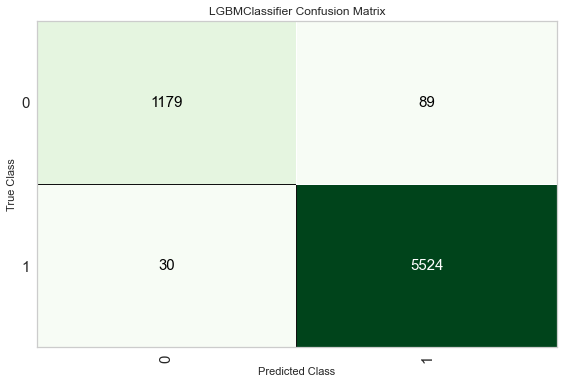

In [541]:
plot_model(final_lgbm, plot='confusion_matrix')

## Finally - Exporting the Classfication Label

In [564]:
sub_class = unseen_predictions['Label']
sub_class.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

In [565]:
sub_class.to_csv("model/sub_class.csv",index=False)

In [566]:
pd.read_csv("model/sub_class.csv")

,Label
0,0
1,0
2,0
3,0
4,0
...,...
401584,0
401585,0
401586,0
401587,0


Once the model is loaded in the environment, you can simply use it to predict on any new data using the same predict_model() function. Below we have applied the loaded model to predict the same data_unseen that we used in section 8 above.